In [1]:
from collections import OrderedDict

import numpy as np
from scipy.stats import multivariate_normal

import pickle

import matplotlib.pyplot as plt

import gen_metrics
import dists

from math import ceil, sqrt

import pandas as pd

from IPython.display import Markdown, display
import plotting

from tqdm import tqdm

plt.rcParams.update({"font.size": 16})


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

plot_dir = "../plots/toy_plots/Nov2"
_ = os.system(f"mkdir -p {plot_dir}")


In [4]:
metrics = OrderedDict(
    [
        ("wasserstein", (gen_metrics.wasserstein, {}, "Wasserstein Distance")),
        ("fgd", (gen_metrics.frechet_gaussian_distance, {}, "Fréchet Gaussian Distance")),
        ("fgd_inf", (gen_metrics.frechet_gaussian_distance, {}, r"$\mathrm{FGD}_\infty$")),
        # ("mmdub", (gen_metrics.mmd_gaussian_quadratic_biased, {}, "MMD Quadratic Biased Est.")),
        ("mmdu", (gen_metrics.mmd_gaussian_quadratic_unbiased, {}, "MMD Quadratic Unbiased Est.")),
        ("mmdl", (gen_metrics.mmd_gaussian_linear, {}, "MMD Linear Estimator")),
        (
            "mmdup",
            (
                gen_metrics.mmd_poly_quadratic_unbiased,
                {"degree": 3},
                "MMD Poly Deg=3 Quadratic Unbiased Est.",
            ),
        ),
        ("mmdlp", (gen_metrics.mmd_poly_linear, {"degree": 3}, "MMD Poly Deg=3 Linear Estimator")),
        (
            "mmdup4",
            (
                gen_metrics.mmd_poly_quadratic_unbiased,
                {"degree": 4},
                "MMD Poly Deg=4 Quadratic Unbiased Est.",
            ),
        ),
        ("mmdlp4", (gen_metrics.mmd_poly_linear, {"degree": 4}, "MMD Poly Deg=4 Linear Estimator")),
        ("pr", (gen_metrics.pr, {}, ["Precision", "Recall"])),
        ("dc", (gen_metrics.dc, {}, ["Density", "Coverage"])),
    ]
)


In [5]:
true_var = 1.0
true_cov = 0.25
var_factor = 10
mixture_means1 = 0.6
mixture_means2 = 0.75

test_dists = [
    (
        rf"Truth N(0.0 $\mu$, 1.0 $\sigma^2$, 0.25 cov)",
        multivariate_normal([0, 0], [[true_var, true_cov], [true_cov, true_var]]),
    ),
    (
        rf"Shift $\mu_x$ by 1 $\sigma$",
        multivariate_normal([sqrt(true_var), 0], [[true_var, true_cov], [true_cov, true_var]]),
    ),
    (
        rf"Shift $\mu_x$ by 0.1 $\sigma$",
        multivariate_normal(
            [sqrt(true_var) / 10.0, 0], [[true_var, true_cov], [true_cov, true_var]]
        ),
    ),
    (
        rf"Zero covariance",
        multivariate_normal([0, 0], [[true_var, 0], [0, true_var]]),
    ),
    (
        rf"Multiply (co)variances by 10",
        multivariate_normal(
            [0, 0],
            [
                [true_var * var_factor, true_cov * var_factor],
                [true_cov * var_factor, true_var * var_factor],
            ],
        ),
    ),
    (
        rf"Divide (co)variances by 10",
        multivariate_normal(
            [0, 0],
            [
                [true_var / var_factor, true_cov / var_factor],
                [true_cov / var_factor, true_var / var_factor],
            ],
        ),
    ),
    (
        r"Mixture of Two Gaussians 1",
        dists.two_multivariate_normals(
            mixture_means1, true_var - mixture_means1**2, true_cov - mixture_means1**2
        ),
    ),
    (
        r"Mixture of Two Gaussians 2",
        dists.two_multivariate_normals(
            mixture_means2, true_var - mixture_means2**2, true_cov - mixture_means2**2
        ),
    ),
]

# kernel_var = gen_metrics.get_kernel_var(true_samples)
# metrics["mmdub"][1]["kernel_sigma"] = sqrt(true_var)
metrics["mmdu"][1]["kernel_sigma"] = sqrt(true_var)
metrics["mmdl"][1]["kernel_sigma"] = sqrt(true_var)


# Plot distributions

In [6]:
bound = 3
x, y = np.mgrid[-bound:bound:0.01, -bound:bound:0.01]
pos = np.dstack((x, y))


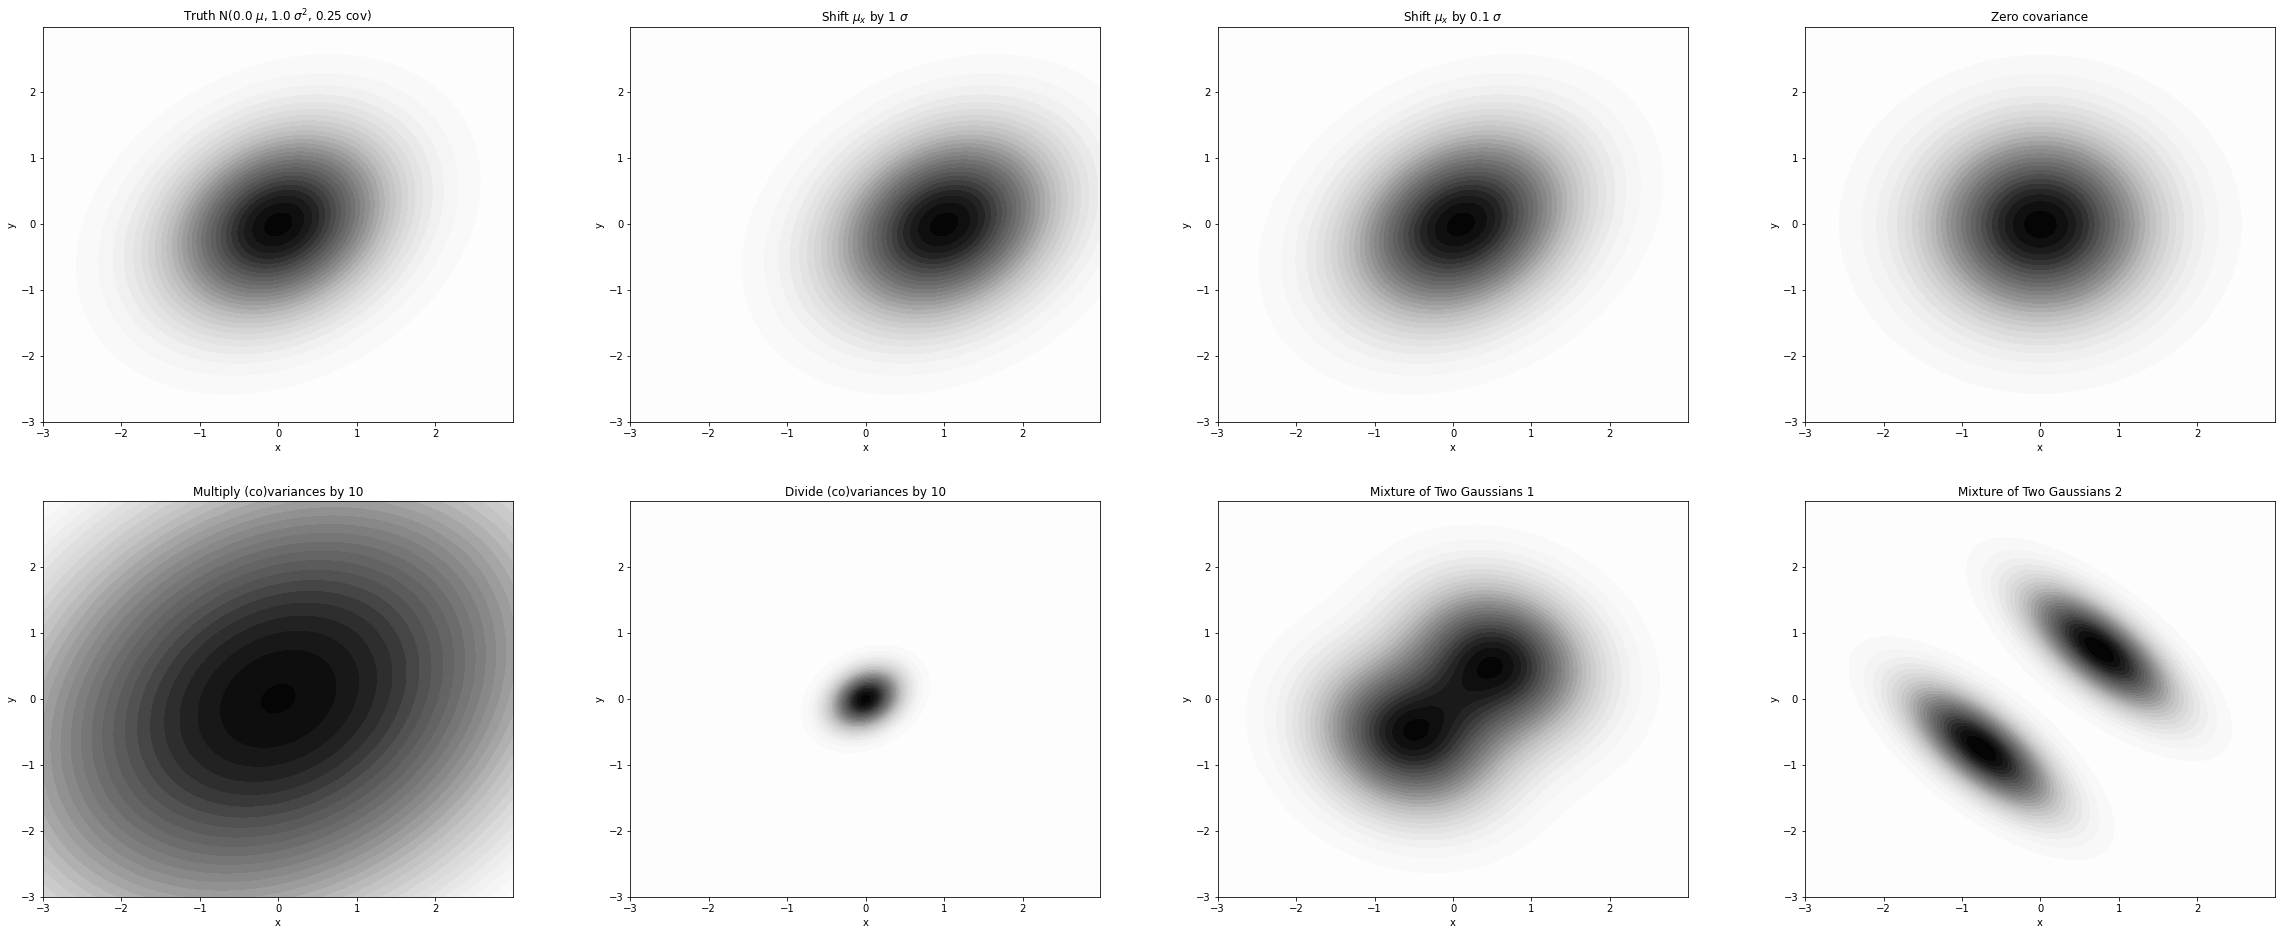

In [7]:
cm = plt.cm.Greys

nrows = 2
ncols = int(ceil(len(test_dists) / nrows))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 10, nrows * 8),
    gridspec_kw={"wspace": 0.25},
)


for i, (label, dist) in enumerate(test_dists):
    row = i // ncols
    col = i % ncols
    axes[row][col].contourf(x, y, dist.pdf(pos), 30, cmap=cm)
    axes[row][col].set_title(label)
    axes[row][col].set_xlabel("x")
    axes[row][col].set_ylabel("y")

plt.savefig(f"{plot_dir}/test_dists.pdf", bbox_inches="tight")


# Measurements

In [8]:
num_batches = 5
tot_num_samples = 50_000

batch_sizes = {
    "wasserstein": [100, 200, 300, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 7000, 10_000],
    "fgd": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000, 7500, 10000, 15000],
    "fgd_inf": [10_000, 15_000, 20_000, 25_000, 30_000, 40_000, 50_000],
    "mmdub": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000],
    "mmdu": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000],
    "mmdl": [
        100,
        200,
        300,
        500,
        750,
        1000,
        1500,
        2000,
        3000,
        5000,
        7500,
        10000,
        15000,
        20000,
        30000,
    ],
    "mmdup": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
    "mmdlp": [
        100,
        200,
        300,
        500,
        750,
        1000,
        1500,
        2000,
        3000,
        5000,
        7500,
        10000,
        15000,
        20000,
        30000,
        40000,
        50000,
    ],
    "mmdup4": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
    "mmdlp4": [
        100,
        200,
        300,
        500,
        750,
        1000,
        1500,
        2000,
        3000,
        5000,
        7500,
        10000,
        15000,
        20000,
        30000,
        40000,
        50000,
    ],
    "pr": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
    "dc": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
}


In [9]:
samples = OrderedDict()

true_samples = test_dists[0][1].rvs(tot_num_samples)

for key, dist in test_dists:
    samples[key] = dist.rvs(tot_num_samples)


In [10]:
metrics["pr"][1]["X_nearest_neighbour_distances"] = {}
metrics["dc"][1]["X_nearest_neighbour_distances"] = {}

# Can save the true sample nearest neighbours
for batch_size in batch_sizes["pr"]:
    xnnd = gen_metrics.compute_nearest_neighbour_distances(true_samples[:batch_size])
    metrics["pr"][1]["X_nearest_neighbour_distances"][batch_size] = xnnd
    metrics["dc"][1]["X_nearest_neighbour_distances"][batch_size] = xnnd


In [118]:
if "measurements" not in locals():
    measurements = OrderedDict()

for dkey, dist in test_dists:
    print(dkey)
    if dkey not in measurements:
        measurements[dkey] = OrderedDict()

    for mkey, (metric, metric_args, label) in metrics.items():
        if mkey in measurements[dkey] or mkey == "fgd_inf":
            continue

        print(mkey)
        ms = []
        ts = []
        for batch_size in tqdm(batch_sizes[mkey]):
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                true_samples,
                samples[dkey],
                num_batches,
                batch_size,
                metric,
                normalise=False,
                timing=True**metric_args,
            )
            ms.append(mean_std)
            ts.append(timing)
        measurements[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


Truth N(0.0 $\mu$, 1.0 $\sigma^2$, 0.25 cov)
mmdup4
$\mu_x$ += 1.0
mmdup4
$\mu_x$ += 0.1
mmdup4
0 cov
mmdup4
$\sigma^2$ x= 10
mmdup4
$\sigma^2$ /= 10
mmdup4
Mixture of Two Gaussians
mmdup4
Mixture of Two Gaussians Far
wasserstein


RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/opt/anaconda3/envs/python310/lib/python3.10/site-packages/ot/lp/__init__.py:547: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
RESULT MIGHT BE INACURATE
Max number of iteration

fgd
mmdu
mmdl
mmdup
mmdlp
mmdup4
mmdlp4
pr
dc


In [50]:
if "measurements" not in locals():
    measurements = OrderedDict()

for dkey, dist in test_dists:
    print(dkey)
    if dkey not in measurements:
        measurements[dkey] = OrderedDict()
    for mkey, (metric, metric_args, label) in metrics.items():
        if mkey in measurements[dkey] or mkey == "fgd_inf":  # not mkey.startswith("mmdu"): #
            continue

        ms = list(measurements[dkey][mkey]["mean_std"])
        ts = list(measurements[dkey][mkey]["timing"])

        for batch_size in tqdm(batch_sizes[mkey][len(ms) :]):
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                true_samples,
                samples[dkey],
                num_batches,
                batch_size,
                metric,
                normalise=False,
                timing=True,
                **metric_args
            )
            ms.append(mean_std)
            ts.append(timing)

        measurements[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


Truth N(0.0 $\mu$, 1.0 $\sigma^2$, 0.25 cov)
$\mu_x$ += 1.0
$\mu_x$ += 0.1
0 cov
$\sigma^2$ x= 10
$\sigma^2$ /= 10
Mixture of Two Gaussians


In [20]:
for dkey, dist in test_dists:
    if "Mixture of Two Gaussians 2" not in dkey:
        continue

    print(dkey)
    
    for mkey, (metric, metric_args, label) in metrics.items():
        if mkey != "wasserstein":  # not mkey.startswith("mmdu"): #
            continue

        print(mkey)

        ms = list(measurements[dkey][mkey]["mean_std"])
        ts = list(measurements[dkey][mkey]["timing"])

        for i, batch_size in tqdm(enumerate(batch_sizes[mkey][:-4])):
            mean_std, timing = gen_metrics.multi_batch_evaluation(
                true_samples,
                samples[dkey],
                num_batches,
                batch_size,
                metric,
                normalise=False,
                timing=True,
                **metric_args
            )
            ms[i] = mean_std
            ts[i] = timing
            # ms.append(mean_std)
            # ts.append(timing)

        measurements[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


Mixture of Two Gaussians 2
wasserstein


10it [00:14,  1.46s/it]


### FGD Infinity

In [14]:
mkey = "fgd_inf"

for dkey, dist in test_dists:
    ms = []
    for n in tqdm(batch_sizes[mkey], desc=dkey):
        ms.append(gen_metrics.one_over_n_extrapolation_repeated_measurements(true_samples, samples[dkey], gen_metrics.frechet_gaussian_distance, normalise=False, max_samples=n))

    measurements[dkey][mkey] = {"mean_std": np.array(ms)}
    

Mixture of Two Gaussians 2: 100%|██████████| 7/7 [00:10<00:00,  1.57s/it]


In [23]:
test_dists

[('Truth N(0.0 $\\mu$, 1.0 $\\sigma^2$, 0.25 cov)',
  <scipy.stats._multivariate.multivariate_normal_frozen at 0x144717520>),
 ('Shift $\\mu_x$ by 1 $\\sigma$',
  <scipy.stats._multivariate.multivariate_normal_frozen at 0x1447174f0>),
 ('Shift $\\mu_x$ by 0.1 $\\sigma$',
  <scipy.stats._multivariate.multivariate_normal_frozen at 0x1447173d0>),
 ('Zero covariance',
  <scipy.stats._multivariate.multivariate_normal_frozen at 0x144717310>),
 ('Multiply (co)variances by 10',
  <scipy.stats._multivariate.multivariate_normal_frozen at 0x144717220>),
 ('Divide (co)variances by 10',
  <scipy.stats._multivariate.multivariate_normal_frozen at 0x144717130>),
 ('Mixture of Two Gaussians 1',
  <dists.two_multivariate_normals at 0x144717040>),
 ('Mixture of Two Gaussians 2',
  <dists.two_multivariate_normals at 0x144716bf0>)]

In [15]:
# with open(f"{plot_dir}/measurements.pkl", "wb") as f:
#     pickle.dump(measurements, f)


In [11]:
with open(f"../plots/toy_plots/Nov2/measurements.pkl", "rb") as f:
    measurements = pickle.load(f)


In [41]:
# measurements = OrderedDict()

# for i in range(len(test_dists)):
#     measurements[test_dists[i][0]] = measurements_old[list(measurements_old.keys())[i]]


# Plot Metrics

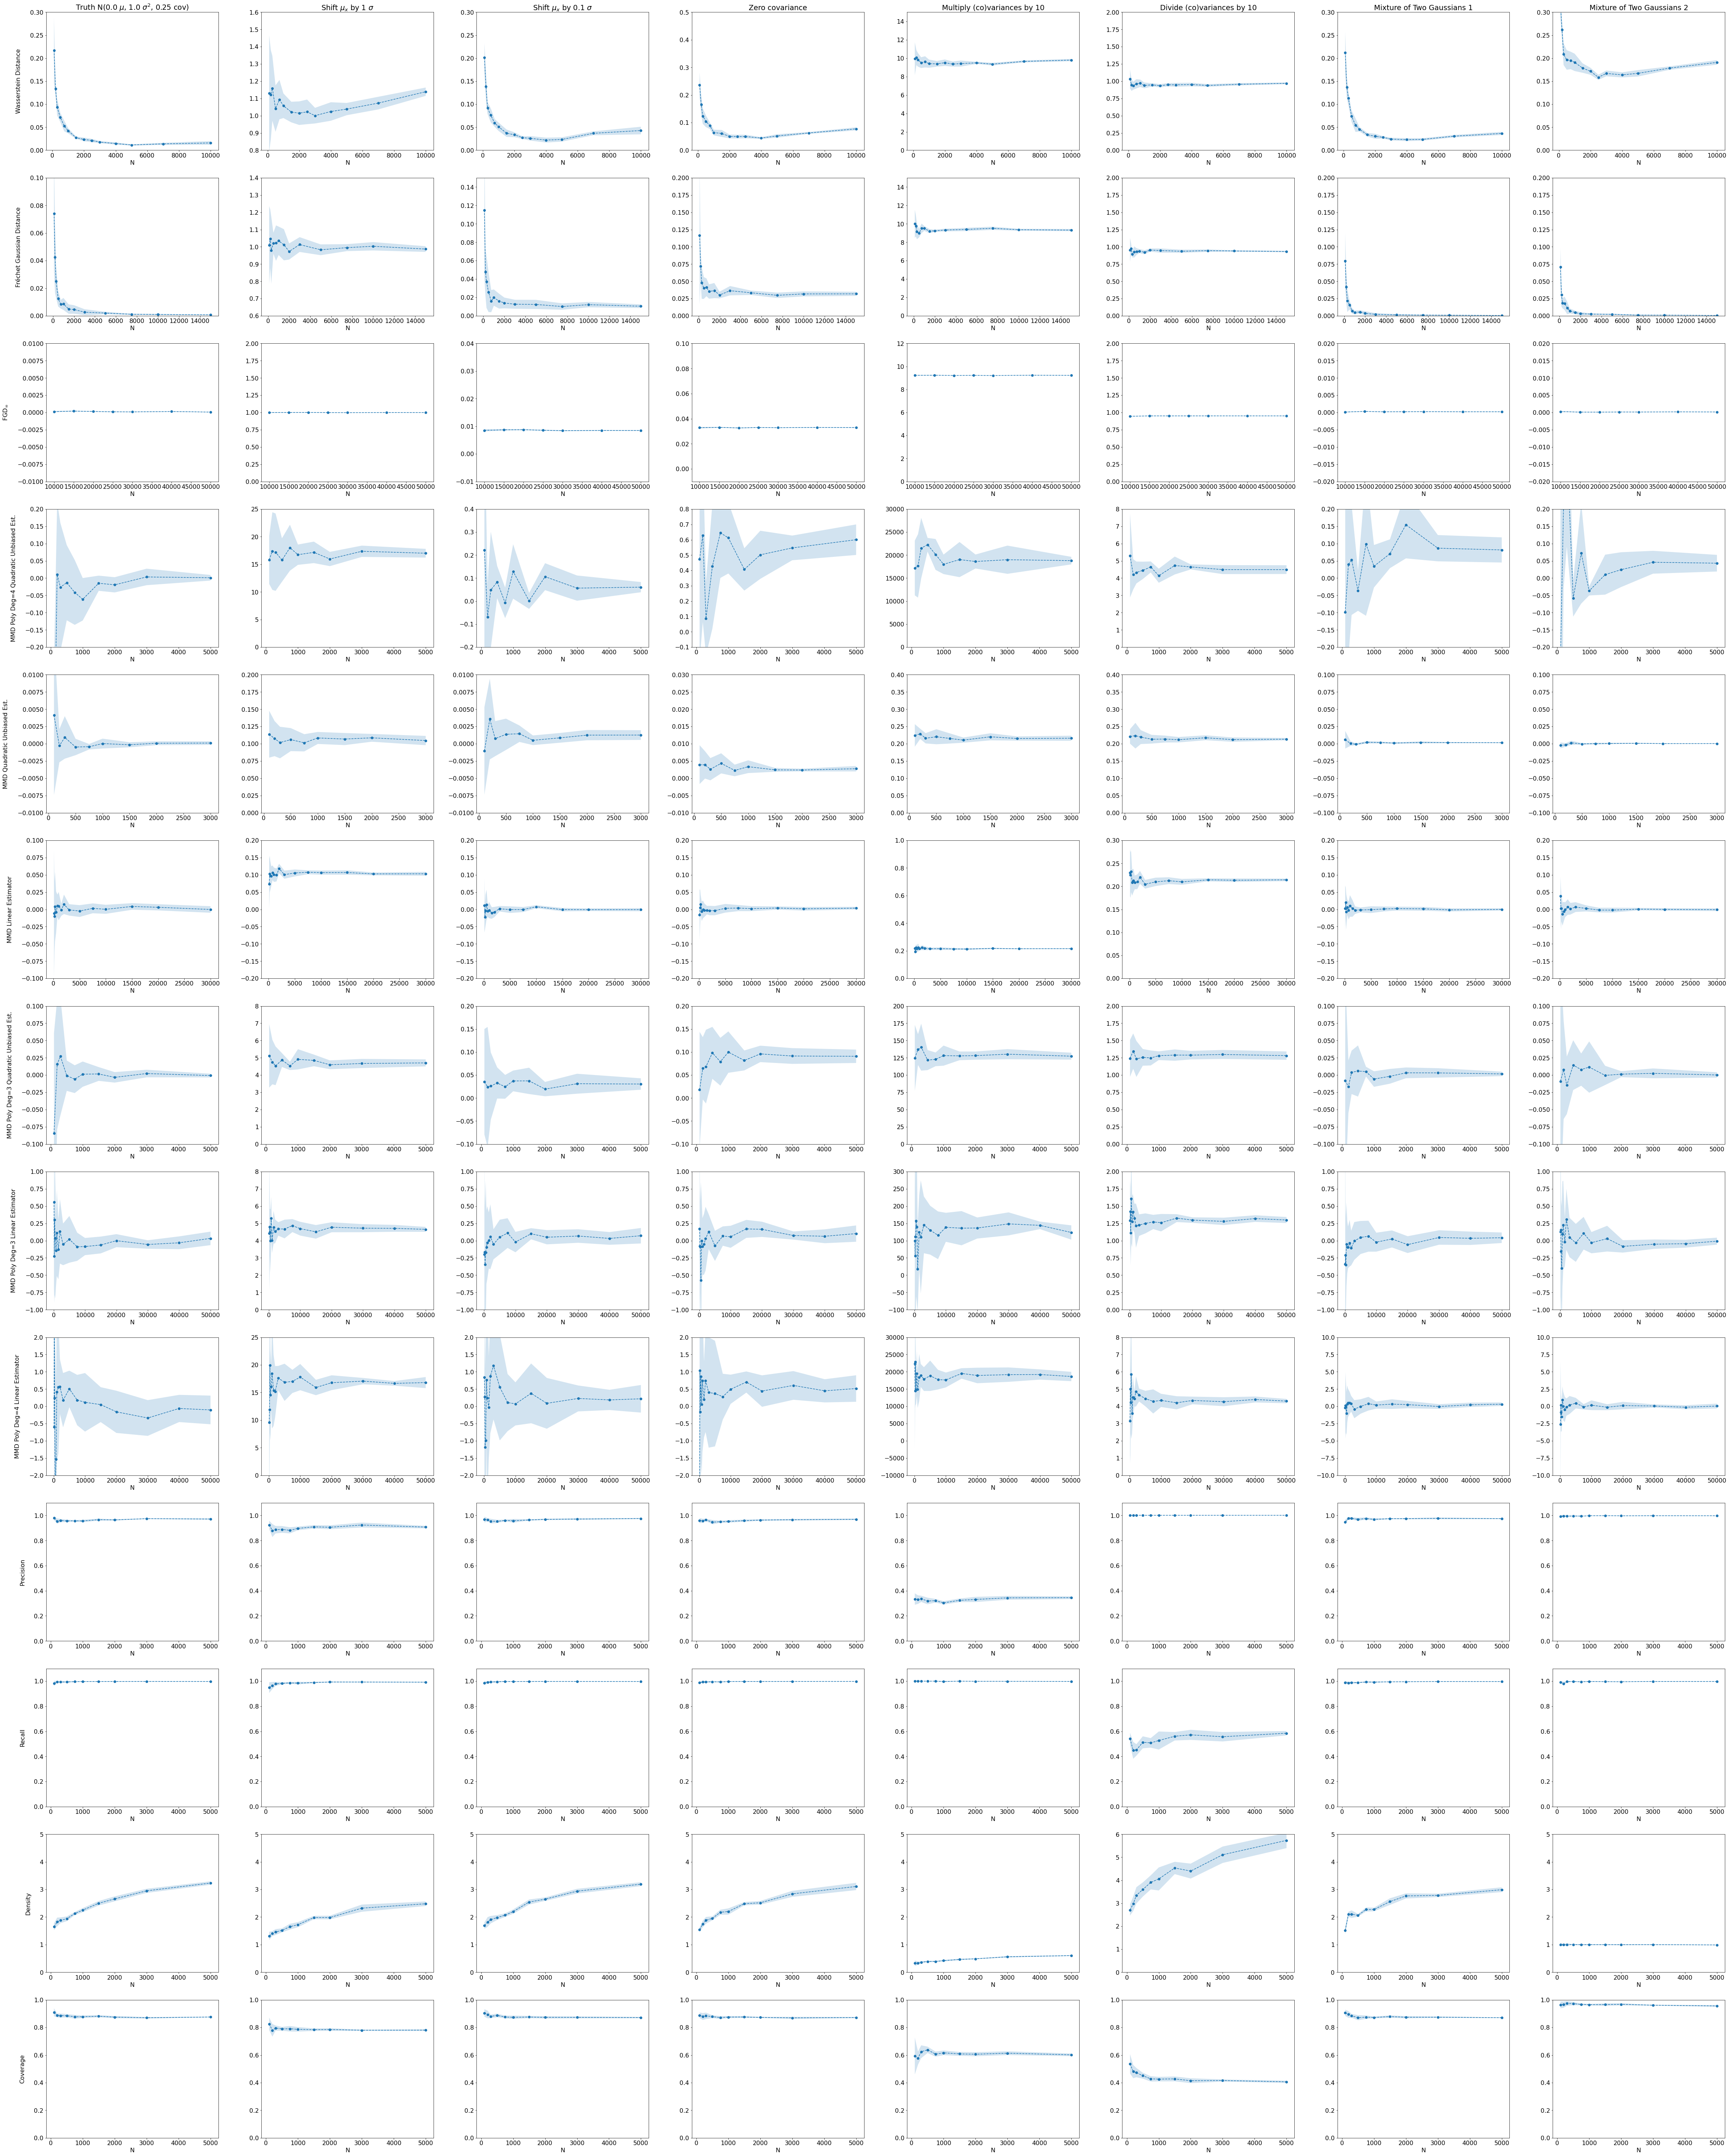

In [16]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        (
            "wasserstein",
            ([0, 0.3], [0.8, 1.6], [0, 0.3], [0, 0.5], [0, 15], [0, 2], [0, 0.3], [0, 0.3]),
        ),
        ("fgd", ([0, 0.1], [0.6, 1.4], [0, 0.15], [0, 0.2], [0, 15], [0, 2], [0, 0.2], [0, 0.2])),
        (
            "fgd_inf",
            (
                [-0.01, 0.01],
                [0, 2],
                [-0.01, 0.04],
                [-0.01, 0.1],
                [0, 12],
                [0, 2],
                [-0.02, 0.02],
                [-0.02, 0.02],
            ),
        ),
        (
            "mmdup4",
            (
                [-0.2, 0.2],
                [0, 25],
                [-0.2, 0.4],
                [-0.1, 0.8],
                [0, 30000],
                [0, 8],
                [-0.2, 0.2],
                [-0.2, 0.2],
            ),
        ),
        # ("mmdub", ([0, 0.02], [0, 0.2], [0, 0.02], [0, 1], [0, 0.2], [-0.1, 0.1])),
        (
            "mmdu",
            (
                [-0.01, 0.01],
                [0, 0.2],
                [-0.01, 0.01],
                [-0.01, 0.03],
                [0, 0.4],
                [0, 0.4],
                [-0.1, 0.1],
                [-0.1, 0.1],
            ),
        ),
        (
            "mmdl",
            (
                [-0.1, 0.1],
                [-0.2, 0.2],
                [-0.2, 0.2],
                [-0.2, 0.2],
                [0, 1],
                [0, 0.3],
                [-0.2, 0.2],
                [-0.2, 0.2],
            ),
        ),
        (
            "mmdup",
            (
                [-0.1, 0.1],
                [0, 8],
                [-0.1, 0.2],
                [-0.1, 0.2],
                [0, 200],
                [0, 2],
                [-0.1, 0.1],
                [-0.1, 0.1],
            ),
        ),
        ("mmdlp", ([-1, 1], [0, 8], [-1, 1], [-1, 1], [-100, 300], [0, 2], [-1, 1], [-1, 1])),
        (
            "mmdlp4",
            ([-2, 2], [0, 25], [-2, 2], [-2, 2], [-10000, 30000], [0, 8], [-10, 10], [-10, 10]),
        ),
        (
            "precision",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
        (
            "recall",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
        ("density", ([0, 5], [0, 5], [0, 5], [0, 5], [0, 5], [0, 6], [0, 5], [0, 5])),
        ("coverage", ([0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1])),
    ]
)

fig, axes = plt.subplots(
    nrows=len(ylims),
    ncols=len(test_dists),
    figsize=(len(test_dists) * 10, len(ylims) * 8),
    gridspec_kw={"wspace": 0.25},
)

for (mkey, (metric, metric_args, label)) in metrics.items():
    if mkey in ["dc", "pr"]:
        continue

    i = list(ylims.keys()).index(mkey)

    plotting.metric_label(axes[i][0], label)
    for j, (dkey, _) in enumerate(test_dists):
        if i == 0:
            axes[i][j].set_title(dkey)

        plotting.plot_means_stds(
            axes[i][j],
            measurements[dkey][mkey]["mean_std"][: len(batch_sizes[mkey])],
            batch_sizes[mkey],
            ylims[mkey][j],
        )

for k, key in enumerate(["precision", "recall"]):
    i = len(ylims) - 4 + k
    mkey = "pr"

    plotting.metric_label(axes[i][0], metrics[mkey][2][k])

    for j, (dkey, _) in enumerate(test_dists):
        plotting.plot_means_stds(
            axes[i][j],
            measurements[dkey][mkey]["mean_std"][:, :, k],
            batch_sizes[mkey],
            ylims[key][j],
        )


for k, key in enumerate(["density", "coverage"]):
    i = len(ylims) - 2 + k
    mkey = "dc"

    plotting.metric_label(axes[i][0], metrics[mkey][2][k])
    for j, (dkey, _) in enumerate(test_dists):
        plotting.plot_means_stds(
            axes[i][j],
            measurements[dkey][mkey]["mean_std"][:, :, k],
            batch_sizes[mkey],
            ylims[key][j],
        )


plt.savefig(f"{plot_dir}/scores.pdf", bbox_inches="tight")


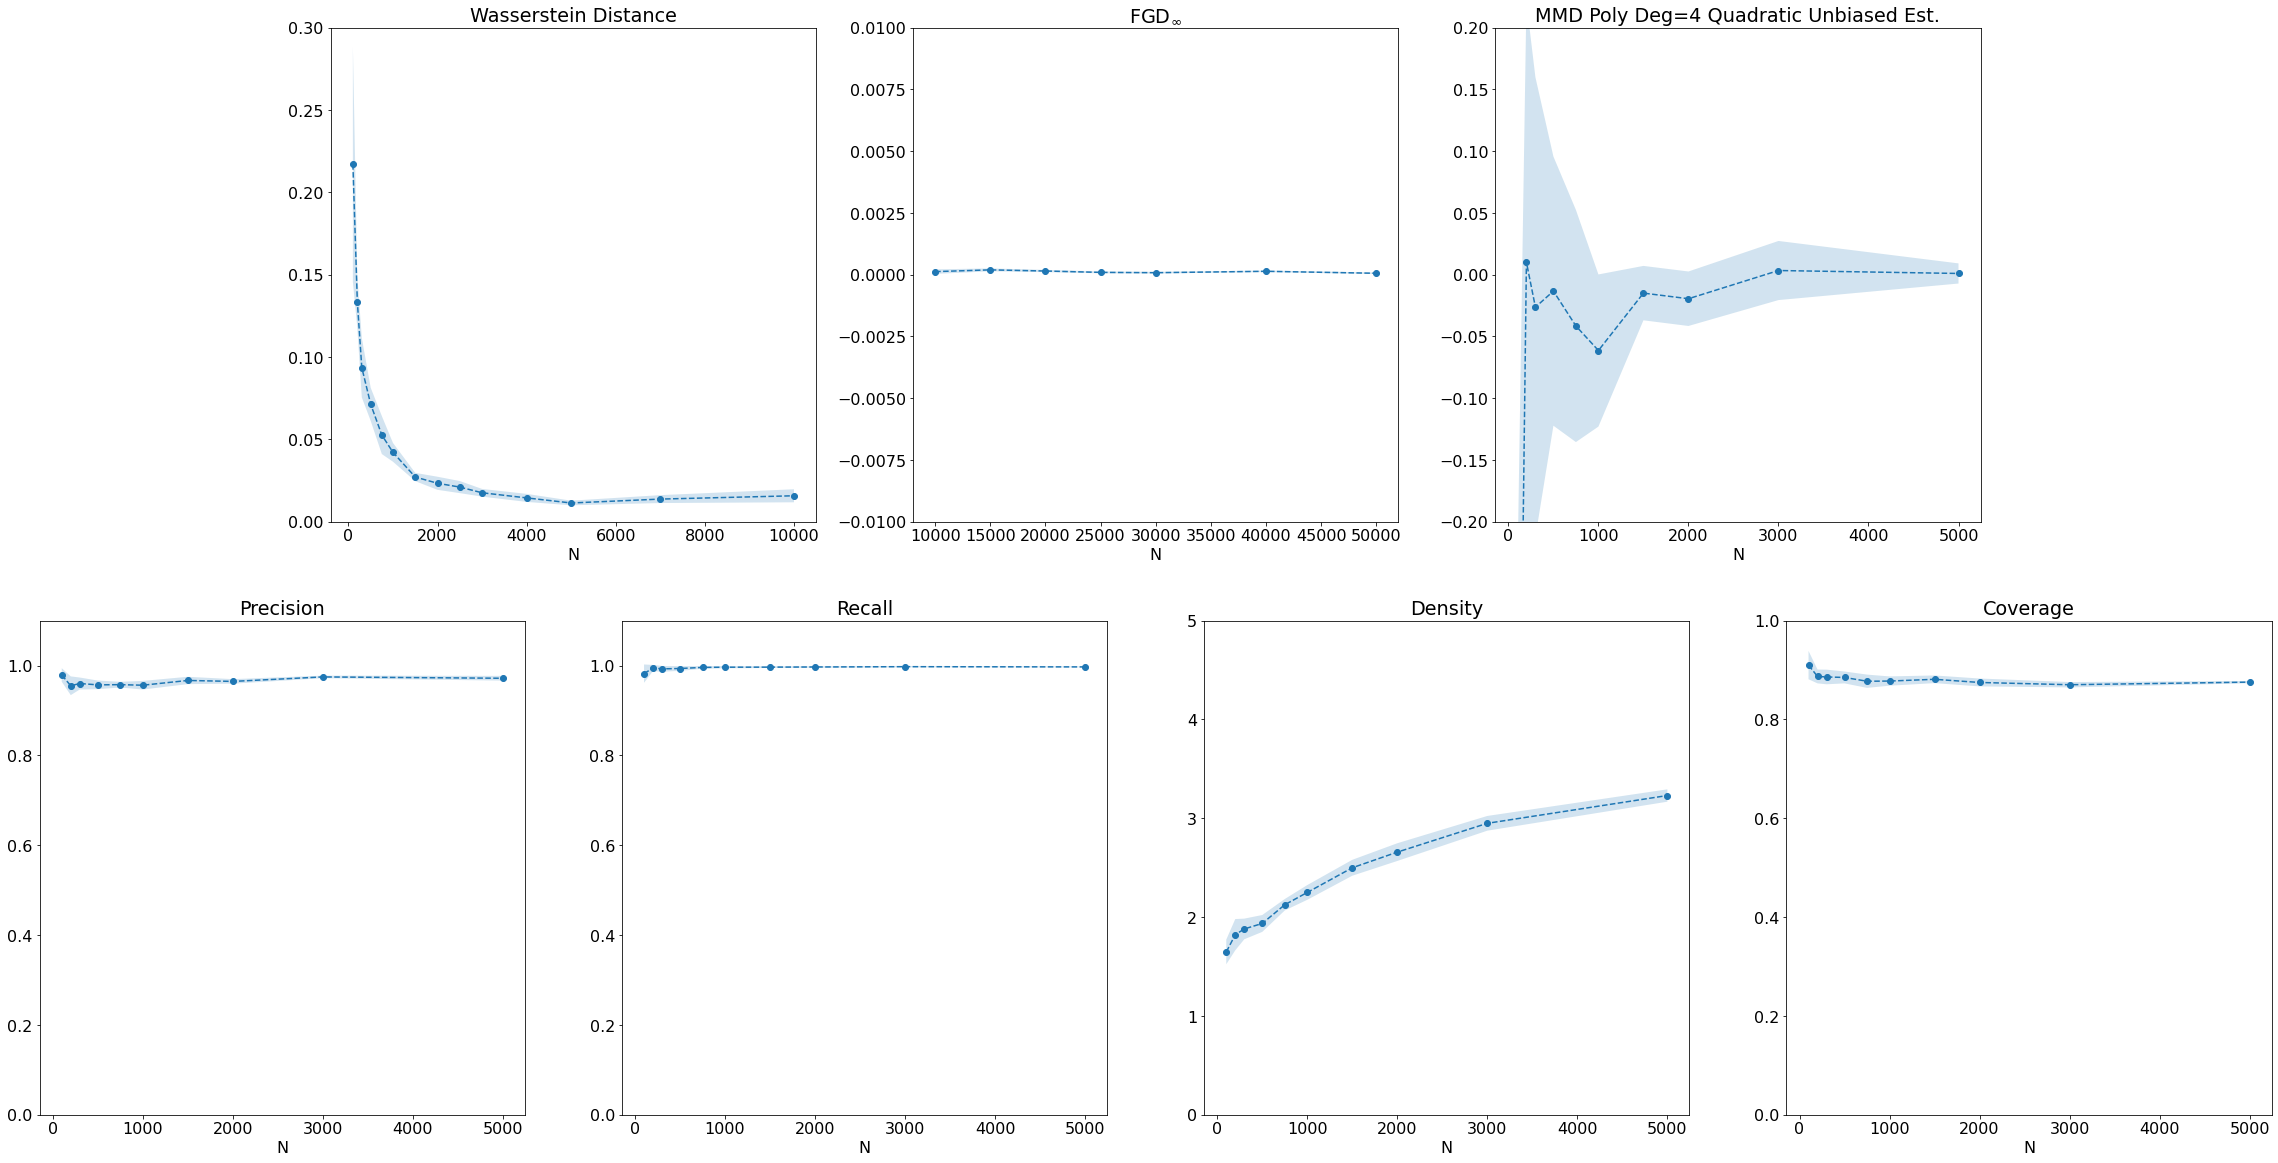

In [17]:
import matplotlib.gridspec as gridspec

plot_metrics = ['wasserstein', 'fgd_inf', 'mmdup4', 'precision', 'recall', 'density', 'coverage']

plt.figure(figsize=(40, 20))
gs = gridspec.GridSpec(2, 8)
gs.update(wspace=0.5)

dkey = 'Truth N(0.0 $\\mu$, 1.0 $\\sigma^2$, 0.25 cov)'

for i, mkey in enumerate(plot_metrics):
    if i < 3:
        ax = plt.subplot(gs[0,  i * 2 + 1:i * 2 + 3])

        plotting.plot_means_stds(
            ax,
            measurements[dkey][mkey]["mean_std"][: len(batch_sizes[mkey])],
            batch_sizes[mkey],
            ylims[mkey][0],
        )
        ax.set_title(metrics[mkey][2])
    else:
        ax = plt.subplot(gs[1, (i - 3) * 2: (i - 3) * 2 + 2])
        ylim = ylims[mkey][0]

        match mkey:
            case "precision":
                mkey = "pr"
                k = 0
            case "recall":
                mkey = "pr"
                k = 1
            case "density":
                mkey = "dc"
                k = 0
            case "coverage":
                mkey = "dc"
                k = 1

        plotting.plot_means_stds(
            ax,
            measurements[dkey][mkey]["mean_std"][:, :, k],
            batch_sizes[mkey],
            ylim,
        )
    
        ax.set_title(metrics[mkey][2][k])

plt.savefig(f"{plot_dir}/truth_scores.pdf", bbox_inches="tight")
    

# Table of values

In [18]:
def print_mean_std(mean_stds: np.ndarray):
    return f"{mean_stds[0]:.3f} ± {mean_stds[1]:.3f}"


rows = []

for mkey, (metric, metric_args, label) in metrics.items():
    if mkey.startswith("mmd") and mkey != "mmdup4":
        continue

    if isinstance(label, list):
        for i, l in enumerate(label):
            row = [l]

            for dkey, values in measurements.items():
                row.append(
                    print_mean_std(values[mkey]["mean_std"][: len(batch_sizes[mkey])][-1, :, i])
                )

            rows.append(row)

    else:
        row = [label]

        for dkey, values in measurements.items():
            row.append(print_mean_std(values[mkey]["mean_std"][: len(batch_sizes[mkey])][-1, :]))

        rows.append(row)

results = pd.DataFrame(rows, columns=["Metric"] + list(measurements.keys()))

display(Markdown(results.to_markdown()))


|    | Metric                                 | Truth N(0.0 $\mu$, 1.0 $\sigma^2$, 0.25 cov)   | Shift $\mu_x$ by 1 $\sigma$   | Shift $\mu_x$ by 0.1 $\sigma$   | Zero covariance   | Multiply (co)variances by 10   | Divide (co)variances by 10   | Mixture of Two Gaussians 1   | Mixture of Two Gaussians 2   |
|---:|:---------------------------------------|:-----------------------------------------------|:------------------------------|:--------------------------------|:------------------|:-------------------------------|:-----------------------------|:-----------------------------|:-----------------------------|
|  0 | Wasserstein Distance                   | 0.016 ± 0.004                                  | 1.139 ± 0.024                 | 0.043 ± 0.008                   | 0.077 ± 0.006     | 9.792 ± 0.126                  | 0.969 ± 0.013                | 0.036 ± 0.003                | 0.191 ± 0.005                |
|  1 | Fréchet Gaussian Distance              | 0.001 ± 0.000                                  | 0.987 ± 0.016                 | 0.010 ± 0.002                   | 0.032 ± 0.003     | 9.320 ± 0.121                  | 0.932 ± 0.010                | 0.001 ± 0.000                | 0.001 ± 0.000                |
|  2 | FGD$_\infty$                           | 0.000 ± 0.000                                  | 0.998 ± 0.002                 | 0.008 ± 0.000                   | 0.033 ± 0.000     | 9.225 ± 0.008                  | 0.950 ± 0.001                | 0.000 ± 0.000                | 0.000 ± 0.000                |
|  3 | MMD Poly Deg=4 Quadratic Unbiased Est. | 0.001 ± 0.008                                  | 17.006 ± 0.791                | 0.061 ± 0.022                   | 0.600 ± 0.100     | 18799.704 ± 822.513            | 4.492 ± 0.254                | 0.082 ± 0.036                | 0.043 ± 0.024                |
|  4 | Precision                              | 0.972 ± 0.005                                  | 0.907 ± 0.010                 | 0.976 ± 0.004                   | 0.969 ± 0.006     | 0.345 ± 0.011                  | 1.000 ± 0.000                | 0.975 ± 0.003                | 0.998 ± 0.001                |
|  5 | Recall                                 | 0.997 ± 0.001                                  | 0.992 ± 0.003                 | 0.997 ± 0.001                   | 0.998 ± 0.001     | 0.998 ± 0.001                  | 0.585 ± 0.018                | 0.996 ± 0.001                | 0.997 ± 0.001                |
|  6 | Density                                | 3.230 ± 0.063                                  | 2.480 ± 0.083                 | 3.190 ± 0.071                   | 3.107 ± 0.132     | 0.603 ± 0.015                  | 5.731 ± 0.336                | 2.990 ± 0.087                | 0.989 ± 0.009                |
|  7 | Coverage                               | 0.876 ± 0.002                                  | 0.780 ± 0.006                 | 0.872 ± 0.005                   | 0.872 ± 0.004     | 0.602 ± 0.010                  | 0.406 ± 0.008                | 0.871 ± 0.002                | 0.956 ± 0.006                |

In [39]:
results.to_csv(f"{plot_dir}/scores.csv")


# Plot Timings

In [111]:
timings = OrderedDict()

for mkey in metrics:
    mtimings = []
    for i, batch_size in enumerate(batch_sizes[mkey]):
        mbtimings = []
        for values in measurements.values():
            mbtimings.append(values[mkey]["timing"][i])

        mtimings.append([np.mean(mbtimings), np.std(mbtimings)])

    timings[mkey] = np.array(mtimings)


NameError: name 'timings' is not defined

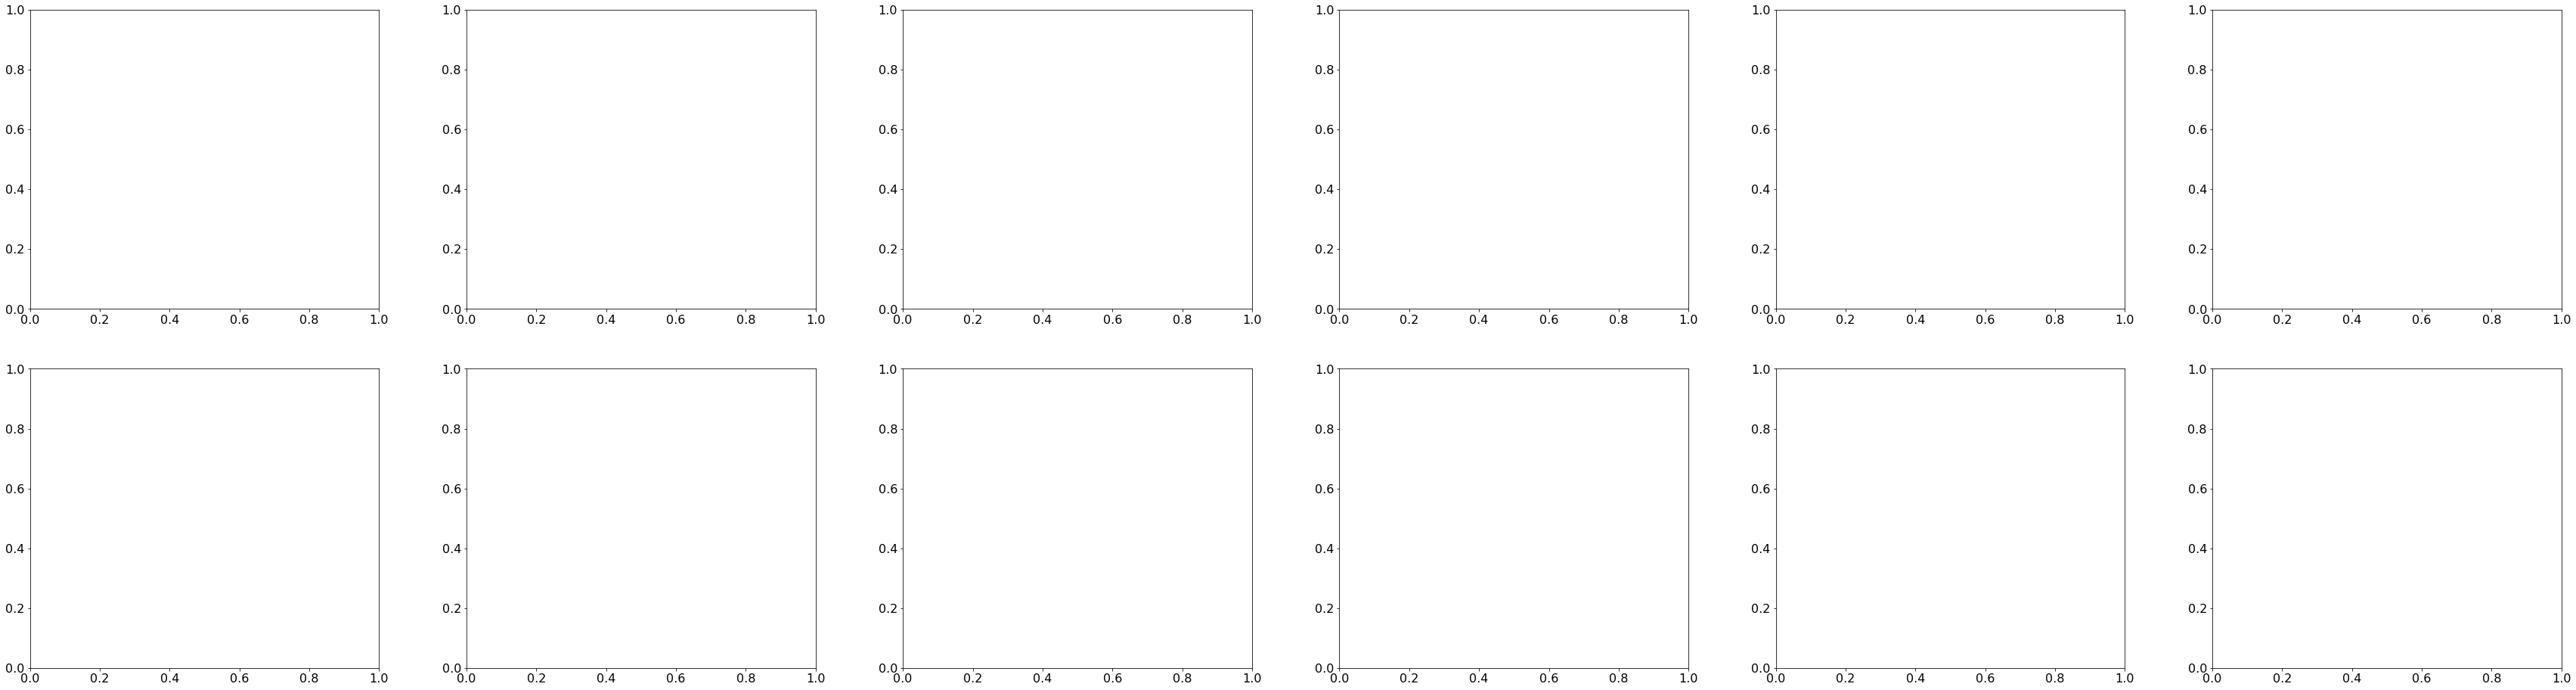

In [34]:
plt.rcParams.update({"font.size": 16})

nrows = 2
ncols = int(ceil(len(metrics) / nrows))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 10, nrows * 8),
    gridspec_kw={"wspace": 0.25},
)

for i, (mkey, (metric, metric_args, label)) in enumerate(metrics.items()):
    row = i // ncols
    col = i % ncols

    if isinstance(label, list):
        label = " & ".join(label)

    means = timings[mkey][:, 0][: len(batch_sizes[mkey])]
    stds = timings[mkey][:, 1][: len(batch_sizes[mkey])]

    axes[row][col].plot(
        batch_sizes[mkey][: len(means)],
        means,
        marker="o",
        linestyle="--",
    )

    axes[row][col].fill_between(
        batch_sizes[mkey][: len(means)], means - stds, means + stds, alpha=0.2
    )
    axes[row][col].set_title(label)
    axes[row][col].set_xlabel("N")
    axes[row][col].set_ylabel("Time (s)")

plt.savefig(f"{plot_dir}/timings.pdf", bbox_inches="tight")
